## Real Estate Market Analysis

The data set used for this analysis was gathered from Zillow.com, and includes 1 bed, 1-2 bathroom condominium units ranging in size from 400 - 1577 square feet. All 256 observations have were sold in San Mateo, CA within the 94401 area code from July 2017 through July 2020. These residences were collected to be used as comparable sales to a 1 bed, 1 bath, 725 square foot condominium in the same area code.


In [26]:
library(tidyverse)
library(xts)
library(ggplot2)
library(forecast)
library(readr)
data <- read_csv("san_mateo_condos_1.csv")
head(data)

Parsed with column specification:
cols(
  date_sold = col_character(),
  price_sold = col_character(),
  bd = col_character(),
  ba = col_character(),
  sqft = col_character(),
  address = col_character()
)



date_sold,price_sold,bd,ba,sqft,address
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sold 08/24/2020,"$655,000",1 bd,1 ba,758 sqft,"904 Peninsula Ave APT 304, San Mateo, CA 94401"
Sold 07/09/2020,"$635,000",1 bd,1 ba,693 sqft,"847 N Humboldt St APT 301, San Mateo, CA 94401"
Sold 07/09/2020,"$615,000",1 bd,1 ba,693 sqft,"815 N Humboldt St APT 401, San Mateo, CA 94401"
Sold 07/02/2020,"$630,000",1 bd,1 ba,693 sqft,"833 N Humboldt St APT 107, San Mateo, CA 94401"
Sold 06/19/2020,"$640,000",1 bd,1 ba,693 sqft,"847 N Humboldt St APT 201, San Mateo, CA 94401"
Sold 05/29/2020,"$640,000",1 bd,1 ba,663 sqft,"1919 Alameda De Las Pulgas APT 1, San Mateo, CA 94403"


A bit of data cleaning.

In [27]:
data$date_sold <-str_remove(data$date_sold, fixed("Sold "))
data$sqft <- str_remove(data$sqft, fixed(" sqft"))
data$price_sold <- str_remove(data$price_sold, fixed("$"))
data$price_sold <- str_remove(data$price_sold, ",")
data$price_sold <- str_remove(data$price_sold, ",")
data$sqft <- str_remove(data$sqft, fixed(","))

Formatting the and creating new attributes to be compatible with timeseries analysis.

In [28]:
date <- as.Date(data$date_sold, format = "%m/%d/%Y")
price <- as.numeric(data$price_sold)
size <- as.numeric(data$sqft)
ppsqft <- price/size
ppsqft <- round(ppsqft, digits = 2)
num <- nrow(data) -1
lag <- c(NA, ppsqft[1:num])
d_ppsqft <- ppsqft - lag
pct_change <- (d_ppsqft/ppsqft)*100

Summary statistics for Price:


In [29]:
summary(price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 100000  581000  635000  654945  713500 2140000 

Summary statistics for square footage:

In [30]:
summary(size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  400.0   693.0   770.0   809.1   894.0  1577.0 

Summary statistics for price per-square-foot:

In [31]:
summary(ppsqft)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  129.2   743.1   831.0   824.5   897.5  2517.7 

Summary statistics for Percentage Change in Price:

In [32]:
summary(pct_change)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max.       NA's 
-1370.5882   -13.9670    -0.0698   -12.3135    13.6207    83.9533          1 

Formatting for Time Series Analysis:

In [33]:
#converting price to xts
price.xts <- as.xts(price, date)

#converting to monthly average
price.xts.mo.av <- apply.monthly(price.xts, mean)
price.xts.mo.av <- round(price.xts.mo.av, digits = 2)

#converting ppsqft to xts
ppsqft.xts <- as.xts(ppsqft, date)

#converting to montly average
ppsqft.xts.mo.av <- apply.monthly(ppsqft.xts, mean)
ppsqft.xts.mo.av <- round(ppsqft.xts.mo.av, digits = 2)

#converting d_ppsqft to xts
d_ppsqft.xts <- as.xts(d_ppsqft, date)

#converting to monthly average
d_ppsqft.xts.mo.av <- apply.monthly(d_ppsqft.xts, mean)
d_ppsqft.xts.mo.av <- round(d_ppsqft.xts.mo.av, digits = 2)
head(d_ppsqft.xts.mo.av)

#converting pct_change to xts
pct_change.xts <- as.xts(pct_change, date)

#converting to monthly average
pct_change.xts.mo.av <- apply.monthly(pct_change.xts, mean)
pct_change.xts.mo.av <- round(pct_change.xts.mo.av, digits = 2)

Warning message:
"timezone of object (UTC) is different than current timezone ()."


             [,1]
2017-07-28 -27.36
2017-08-30  86.73
2017-09-28 -36.41
2017-10-31  16.77
2017-11-29  -1.55
2017-12-29  -7.63

#### Monthly Average Condo Sales Price

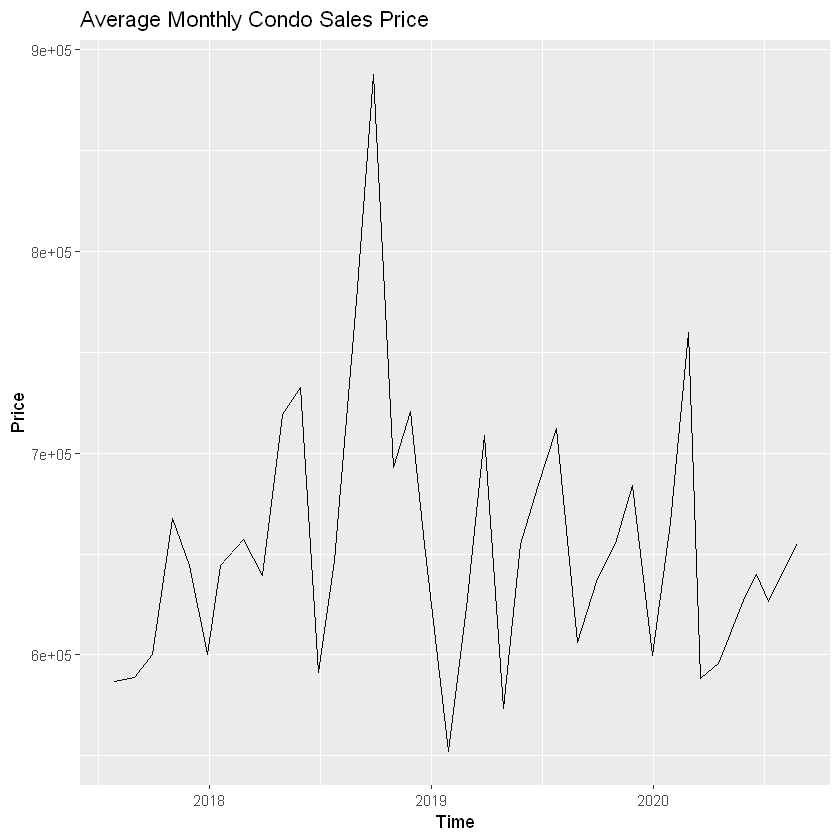

In [34]:
autoplot.zoo(price.xts.mo.av) + ggtitle("Average Monthly Condo Sales Price") + ylab("Price") + xlab("Time")

#### Monthly Average Price per-square-foot

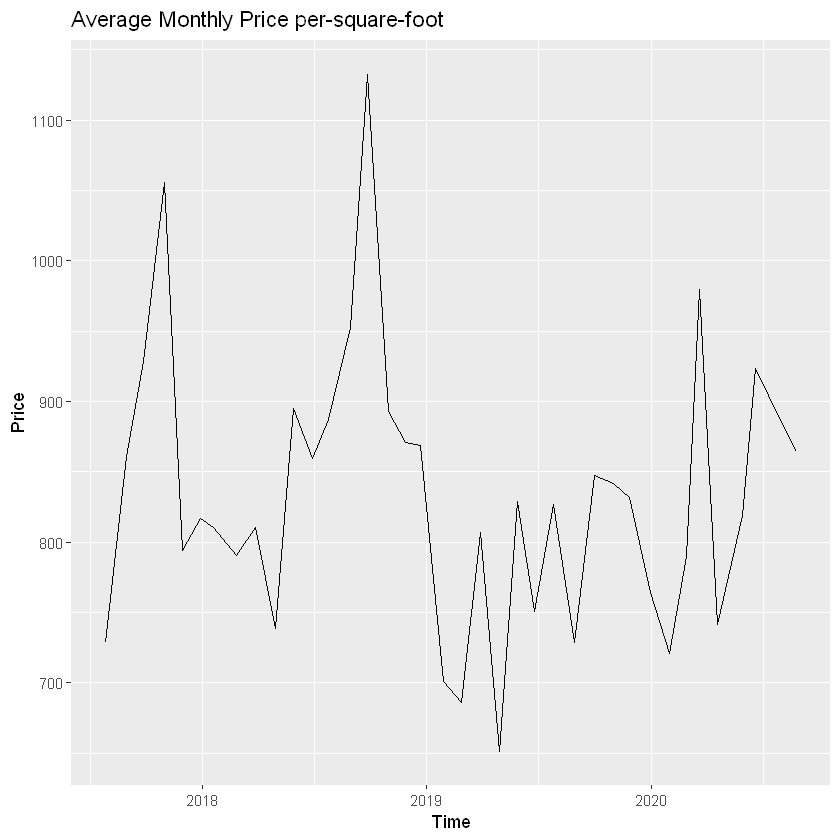

In [35]:
autoplot.zoo(ppsqft.xts.mo.av) + ggtitle("Average Monthly Price per-square-foot") + ylab("Price") + xlab("Time")

12 month Average

In [36]:
mean(ppsqft.xts.mo.av[24:36])

[1] 812.6331

3 month Average

In [37]:
mean(ppsqft.xts.mo.av[33:36])

[1] 865.75

#### Change in Monthly Average per-square-foot Price

Warning message:
"Removed 1 rows containing missing values (geom_path)."


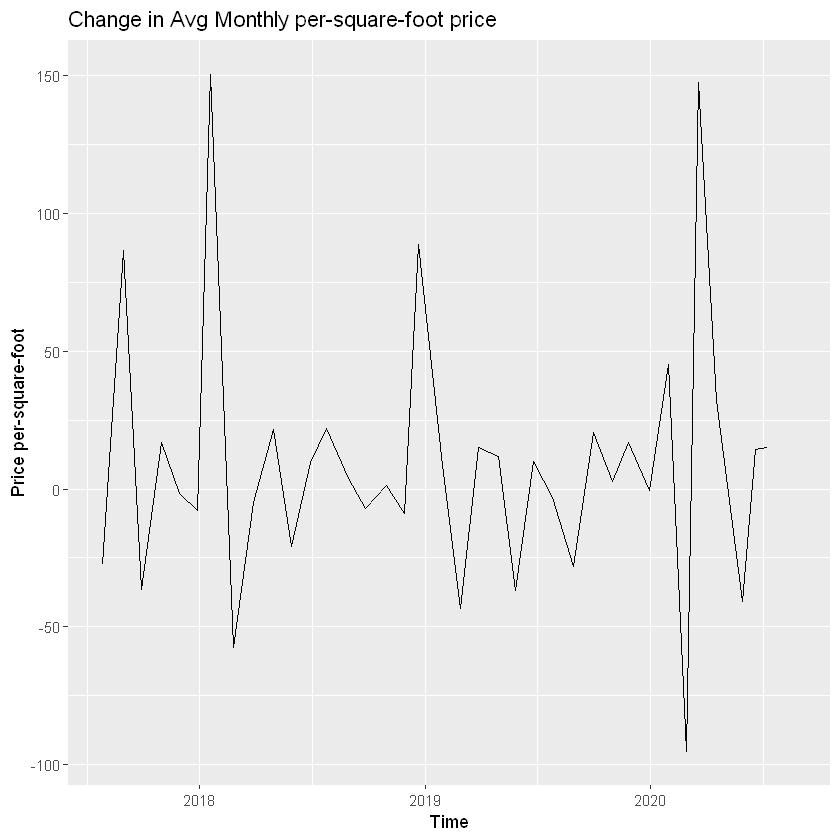

In [38]:
autoplot.zoo(d_ppsqft.xts.mo.av) + ggtitle("Change in Avg Monthly per-square-foot price") + ylab("Price per-square-foot") + xlab("Time")

12 month Average 

In [39]:
mean(d_ppsqft.xts.mo.av[23:35])

[1] 5.358462

3 month Average

In [40]:
mean(d_ppsqft.xts.mo.av[32:35])

[1] 10.835

Percentage Change in Average Monthly per-square-foot Price


Warning message:
"Removed 1 rows containing missing values (geom_path)."


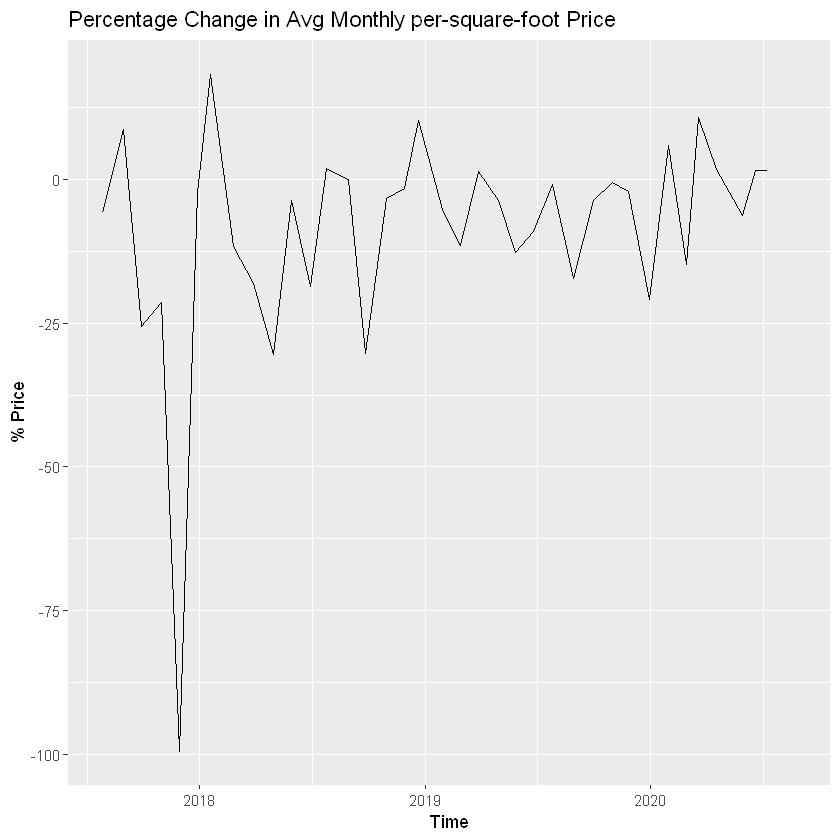

In [41]:
autoplot.zoo(pct_change.xts.mo.av) + ggtitle("Percentage Change in Avg Monthly per-square-foot Price") + ylab("% Price") + xlab("Time")

12 month Average

In [42]:
mean(pct_change.xts.mo.av[23:35])

[1] -5.343077

3 month Average

In [43]:
mean(pct_change.xts.mo.av[32:35])

[1] -2.1

#### Time Series forecast for Monthly Average Change in per-square-foot Price (ARIMA(0,0,1))

Warning message:
"Removed 1 rows containing missing values (geom_path)."


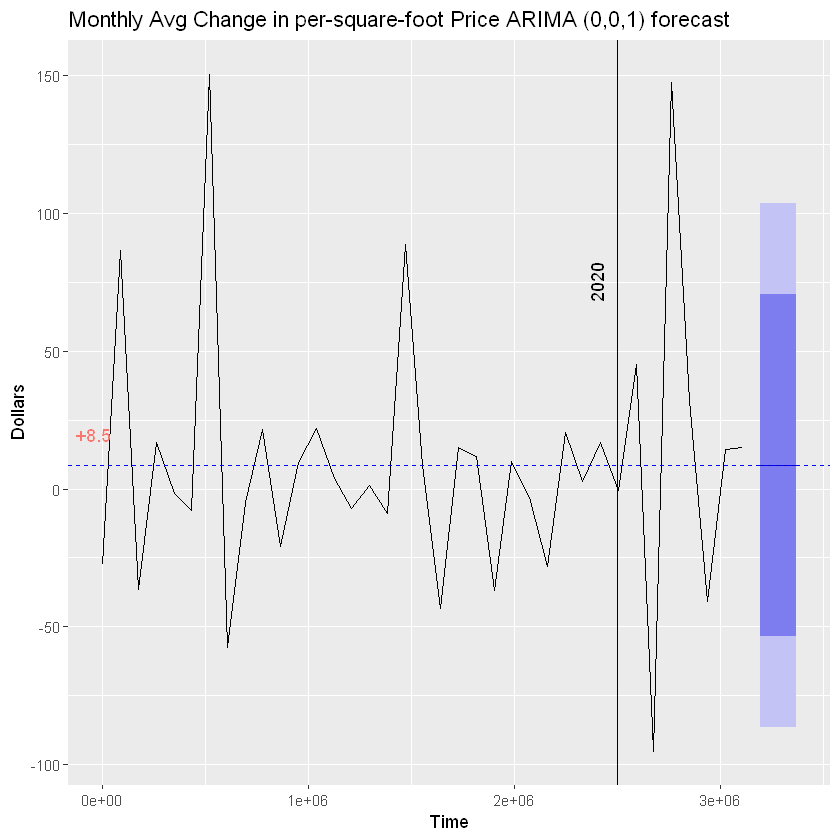

In [44]:
fit1 <- auto.arima(d_ppsqft.xts.mo.av)
fit1 %>% forecast(h=3) %>% autoplot() + ggtitle("Monthly Avg Change in per-square-foot Price ARIMA (0,0,1) forecast") + ylab("Dollars") + geom_hline(yintercept = 8.5, linetype ="dashed", color="blue") + geom_text(aes(y=20, label="+8.5", x=0, color="red", hjust=0.75)) + geom_vline(xintercept=2.5e+06) + geom_text(aes(x=2.5e+06, label="2020", y=75, angle=90, vjust=-1))+ theme(legend.position="none")

The expected value for the 3 month forcasted price change is +$8.5. 

The dark blue region represents the 80% confidence interval, upper bound: +$72, lower bound: -$55. 

The light blue region represents the 90% confidence interval, upper bound: +$105, lower bound: -$80.

#### Time Series forecast for Monthly Average Percentage Change in per-square-foot Price (ARIMA(0,0,0))

Warning message:
"Removed 1 rows containing missing values (geom_path)."


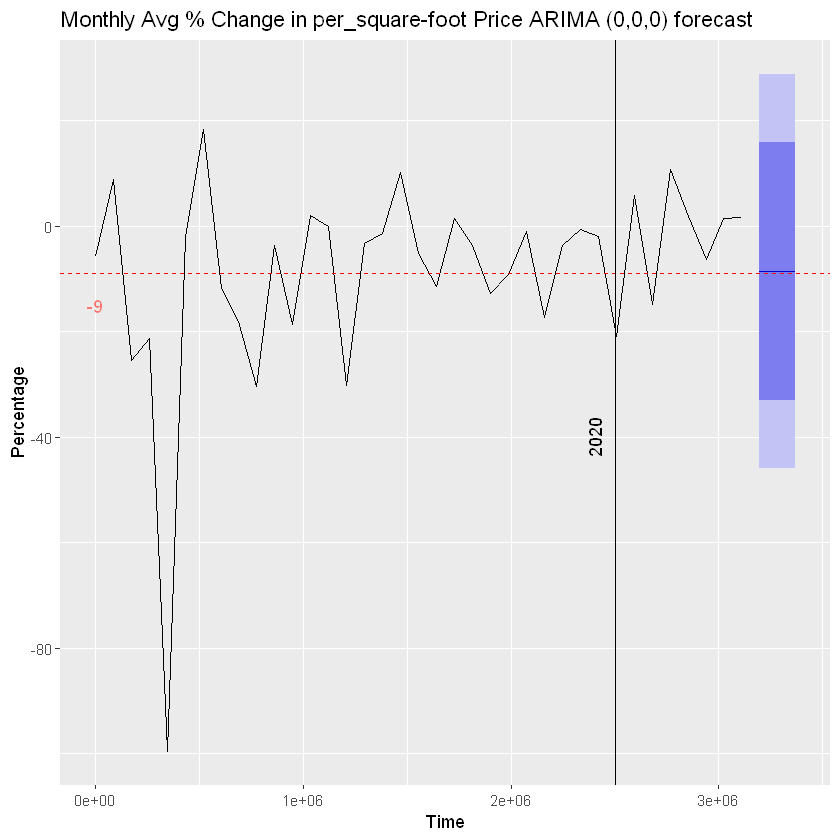

In [45]:
fit2 <- auto.arima(pct_change.xts.mo.av) 
fit2 %>% forecast(h=3) %>% autoplot() + ggtitle("Monthly Avg % Change in per_square-foot Price ARIMA (0,0,0) forecast") + ylab("Percentage") + geom_hline(yintercept = -9, linetype ="dashed", color="red") + geom_text(aes(y=-15, label="-9", x=0, color="red")) + geom_vline(xintercept=2.5e+06) + geom_text(aes(x=2.5e+06, label="2020", y=-40, angle=90, vjust=-1)) + theme(legend.position="none")

The expected value for the 3 month forcasted percentage price change is -9%. 

The dark blue region represents the 80% confidence interval, upper bound: +16%, lower bound: -34%. 

The light blue region represents the 90% confidence interval, upper bound: +30%, lower bound: -46%.
